In [8]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
import copy
from preprocess import preprocess_text
# 1. Load the reviews
DATASET_DIR = r'C:\Users\nourh\Documents\cours 3A ensae\NLP\NLP_course\Mini_project\Data\aclImdb_v1\aclImdb'

def load_reviews(data_dir, dataset_type='train'):
    reviews = []
    sentiments = []
    base_path = os.path.join(data_dir, dataset_type)
    
    for sentiment in ['pos', 'neg']:
        sentiment_path = os.path.join(base_path, sentiment)
        for filename in os.listdir(sentiment_path):
            if filename.endswith('.txt'):
                with open(os.path.join(sentiment_path, filename), 'r', encoding='utf-8') as f:
                    reviews.append(f.read())
                    sentiments.append(sentiment)
    return pd.DataFrame({'review': reviews, 'sentiment': sentiments})

# 2. Load train and test, then merge
train_df = load_reviews(DATASET_DIR, 'train')
test_df = load_reviews(DATASET_DIR, 'test')

train_df_preprocessed= copy.deepcopy(train_df)
test_df_preprocessed= copy.deepcopy(test_df)

train_df_preprocessed ['review'] = train_df_preprocessed ['review'].apply(lambda x: preprocess_text(x, remove_stopwords=True))
test_df_preprocessed ['review'] = test_df_preprocessed ['review'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

## Glove

In [9]:
import numpy as np
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from torch.nn import CrossEntropyLoss
from Advanced_models.tools import AverageMeter, accuracy_topk

# --- 1. Load GloVe embeddings -----------------------------------------------
def load_glove(glove_path):
    """Loads GloVe into a dict: word -> np.array(vector)"""
    emb_dim = None
    glove = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.rstrip().split(' ')
            word, vec = parts[0], np.array(parts[1:], dtype=np.float32)
            glove[word] = vec
            if emb_dim is None:
                emb_dim = vec.shape[0]
    return glove, emb_dim

# --- 2. Embed reviews by averaging -----------------------------------------
def embed_reviews(df, glove, emb_dim):
    """Given df['review'] (preprocessed string), return N x emb_dim array"""
    embeddings = []
    for text in df['review']:
        tokens = text.split()  # assumes preprocess_text joined tokens with spaces
        vecs = [glove[t] for t in tokens if t in glove]
        if len(vecs) > 0:
            emb = np.mean(vecs, axis=0)
        else:
            emb = np.zeros(emb_dim, dtype=np.float32)
        embeddings.append(emb)
    return np.vstack(embeddings)

# --- 3. Prepare data --------------------------------------------------------
# assume `train_df` and `test_df` already exist and have been preprocessed
# and that `glove_path` is a string pointing to your .txt GloVe file.
glove_path ='C:\\Users\\nourh\\Documents\\cours 3A ensae\\NLP\\NLP_course\\TPs\\nlp-lab-text-embedding-main\\nlp-lab-text-embedding-main\\data\\glove.6B.50d.txt\\glove.6B.50d.txt'  # Download from https://nlp.stanford.edu/projects/glove/
  # e.g. adjust as needed
glove, emb_dim = load_glove(glove_path)

X_train = embed_reviews(train_df_preprocessed, glove, emb_dim)
X_test  = embed_reviews(test_df_preprocessed,  glove, emb_dim)

# Encode labels to 0/1
le = LabelEncoder().fit(train_df_preprocessed['sentiment'])
y_train = le.transform(train_df_preprocessed['sentiment'])
y_test  = le.transform(test_df_preprocessed['sentiment'])

# --- 4. Train SVM -----------------------------------------------------------
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

# --- 5. Inference + evaluation ---------------------------------------------
# Get probability estimates as “logits” for CrossEntropyLoss
probs       = clf.predict_proba(X_test)           # shape (N,2)
# For a “logit” approximation, we can use the decision function:
decfunc     = clf.decision_function(X_test)      # shape (N,) for binary
# stack into two-class logits: [-d, +d]
logits      = np.vstack([-decfunc, decfunc]).T   # shape (N,2)

# Convert to torch
outputs = torch.from_numpy(logits)               # FloatTensor (N,2)
targets = torch.from_numpy(y_test).long()        # LongTensor (N,)

# Loss
criterion = CrossEntropyLoss()
test_loss = criterion(outputs, targets).item()

# Accuracy
top1_acc = accuracy_topk(outputs, targets, k=1)  # uses your function

# Use AverageMeter to track loss (if you wanted to accumulate in a loop)
meter = AverageMeter()
meter.update(test_loss, n=targets.size(0))

print(f"Test Loss:    {meter.avg:.4f}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")


Test Loss:    0.5581
Top-1 Accuracy: 75.46%


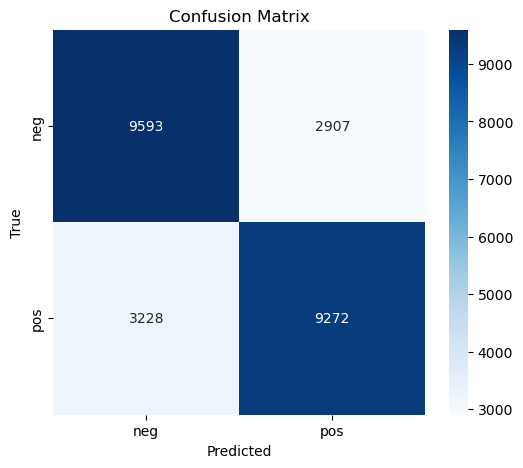

Classification Report:
               precision    recall  f1-score   support

         neg     0.7482    0.7674    0.7577     12500
         pos     0.7613    0.7418    0.7514     12500

    accuracy                         0.7546     25000
   macro avg     0.7548    0.7546    0.7546     25000
weighted avg     0.7548    0.7546    0.7546     25000



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- make hard predictions -----------------------------------------------
y_pred = clf.predict(X_test)

# --- confusion matrix ---------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# --- classification report ---------------------------------------------
report = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    digits=4  # more precise decimals
)
print("Classification Report:\n", report)

## Word2vec

Test Loss:      0.6009
Top-1 Accuracy: 72.93%


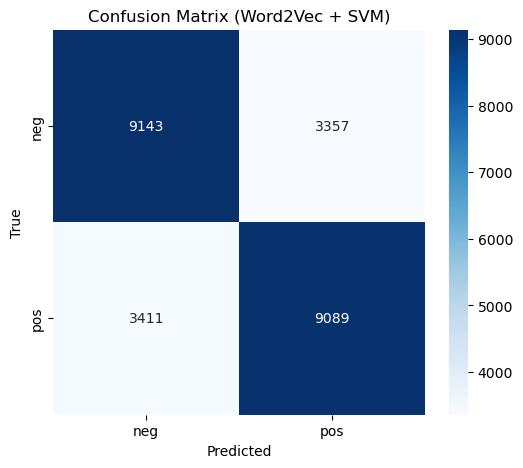

Classification Report:
               precision    recall  f1-score   support

         neg     0.7283    0.7314    0.7299     12500
         pos     0.7303    0.7271    0.7287     12500

    accuracy                         0.7293     25000
   macro avg     0.7293    0.7293    0.7293     25000
weighted avg     0.7293    0.7293    0.7293     25000



In [12]:
import os
import numpy as np
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import KeyedVectors

# --- 1. Load pre-trained Word2Vec -----------------------------------------
# assumes `word2vec_path` points to the GoogleNews-vectors-negative300.bin file
word2vec_path = r'C:\Users\nourh\Documents\cours 3A ensae\NLP\NLP_course\TPs\nlp-lab-text-embedding-main\nlp-lab-text-embedding-main\data\frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin'
w2v = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
emb_dim = w2v.vector_size  # e.g. 300

# --- 2. Embed by averaging Word2Vec ----------------------------------------
def embed_reviews_w2v(df, w2v_model, emb_dim):
    """Average Word2Vec embeddings for each review in df['review']."""
    embeddings = []
    for text in df['review']:
        tokens = text.split()
        vecs = [w2v_model[t] for t in tokens if t in w2v_model]
        if vecs:
            emb = np.mean(vecs, axis=0)
        else:
            emb = np.zeros(emb_dim, dtype=np.float32)
        embeddings.append(emb)
    return np.vstack(embeddings)

# assume train_df and test_df are already preprocessed
X_train = embed_reviews_w2v(train_df_preprocessed, w2v, emb_dim)
X_test  = embed_reviews_w2v(test_df_preprocessed,  w2v, emb_dim)

# --- 3. Prepare labels -----------------------------------------------------
le      = LabelEncoder().fit(train_df_preprocessed['sentiment'])
y_train = le.transform(train_df_preprocessed['sentiment'])
y_test  = le.transform(test_df_preprocessed['sentiment'])

# --- 4. Train SVM -----------------------------------------------------------
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

# --- 5. Inference & loss/accuracy ------------------------------------------
# Decision scores for “logits”
dec = clf.decision_function(X_test)               # (N,) for binary
logits = np.vstack([-dec, dec]).T                # shape (N,2)
outputs = torch.from_numpy(logits).float()        # FloatTensor
targets = torch.from_numpy(y_test).long()         # LongTensor

# Compute loss + accuracy
criterion = CrossEntropyLoss()
test_loss = criterion(outputs, targets).item()
top1_acc  = accuracy_topk(outputs, targets, k=1)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")

# --- 6. Confusion Matrix & Classification Report --------------------------
y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Word2Vec + SVM)')
plt.show()

# Classification report
print("Classification Report:\n",
      classification_report(
          y_test, y_pred,
          target_names=le.classes_,
          digits=4
      )
)


## Bert : static embedding

c:\Users\nourh\miniconda3\envs\mon_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nourh\miniconda3\envs\mon_env\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Test Loss:      0.3695
Top-1 Accuracy: 85.18%


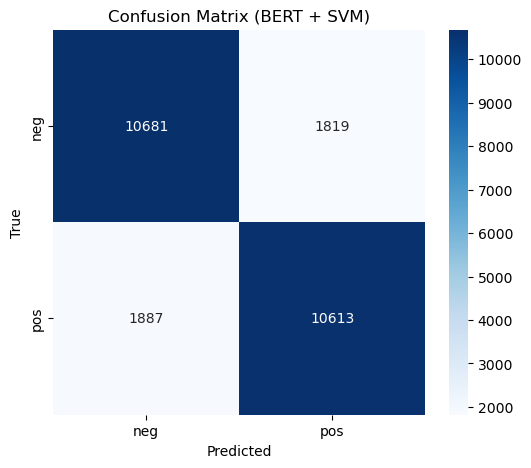

Classification Report:
               precision    recall  f1-score   support

         neg     0.8499    0.8545    0.8522     12500
         pos     0.8537    0.8490    0.8514     12500

    accuracy                         0.8518     25000
   macro avg     0.8518    0.8518    0.8518     25000
weighted avg     0.8518    0.8518    0.8518     25000



In [13]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load BERT + tokenizer ---------------------------------------------
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased',
                                       output_hidden_states=False,
                                       return_dict=True)
bert_model.eval()               # freeze in eval mode
for p in bert_model.parameters():
    p.requires_grad = False

# --- 2. Embed your reviews ------------------------------------------------
def embed_reviews_bert(df, tokenizer, model, device='cpu', batch_size=32):
    """Return an N x hidden_size array of [CLS] embeddings."""
    all_embs = []
    model.to(device)
    for i in range(0, len(df), batch_size):
        batch_texts = df['review'].iloc[i:i+batch_size].tolist()
        # tokenize + pad/truncate
        enc = tokenizer(batch_texts,
                        padding=True,
                        truncation=True,
                        max_length=256,
                        return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            # out.last_hidden_state: (B, seq_len, hidden_size)
            # take [CLS] at position 0
            cls_emb = out.last_hidden_state[:, 0, :].cpu().numpy()
        all_embs.append(cls_emb)
    return np.vstack(all_embs)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train = embed_reviews_bert(train_df, tokenizer, bert_model, device=device)
X_test  = embed_reviews_bert(test_df,  tokenizer, bert_model, device=device)

# --- 3. Labels -------------------------------------------------------------
le      = LabelEncoder().fit(train_df['sentiment'])
y_train = le.transform(train_df['sentiment'])
y_test  = le.transform(test_df['sentiment'])

# --- 4. Train SVM ----------------------------------------------------------
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

# --- 5. Eval: loss & accuracy ---------------------------------------------
# Use decision_function as “logit”
dec    = clf.decision_function(X_test)
logits = np.vstack([-dec, dec]).T
outputs = torch.from_numpy(logits).float()
targets = torch.from_numpy(y_test).long()

criterion = CrossEntropyLoss()
test_loss = criterion(outputs, targets).item()
top1_acc  = accuracy_topk(outputs, targets, k=1)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")

# --- 6. Confusion matrix & classification report --------------------------
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (BERT + SVM)')
plt.show()

print("Classification Report:\n",
      classification_report(y_test, y_pred,
                            target_names=le.classes_,
                            digits=4))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss:      0.2597
Top-1 Accuracy: 89.32%


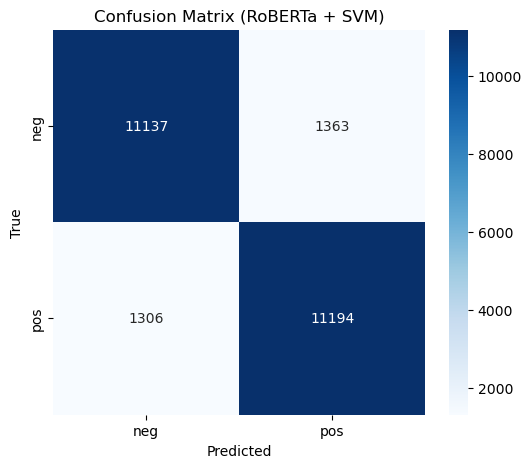

Classification Report:
               precision    recall  f1-score   support

         neg     0.8950    0.8910    0.8930     12500
         pos     0.8915    0.8955    0.8935     12500

    accuracy                         0.8932     25000
   macro avg     0.8932    0.8932    0.8932     25000
weighted avg     0.8932    0.8932    0.8932     25000



In [ ]:
import torch
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load RoBERTa + tokenizer ------------------------------------------
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta = RobertaModel.from_pretrained('roberta-base',
                                       output_hidden_states=False,
                                       return_dict=True)
roberta.eval()
for p in roberta.parameters():
    p.requires_grad = False

# --- 2. Embed your reviews with RoBERTa -----------------------------------
def embed_reviews_roberta(df, tokenizer, model, device='cpu', batch_size=32):
    all_embs = []
    model.to(device)
    for i in range(0, len(df), batch_size):
        texts = df['review'].iloc[i:i+batch_size].tolist()
        enc = tokenizer(texts,
                        padding=True,
                        truncation=True,
                        max_length=256,
                        return_tensors='pt')
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            # Roberta also puts the “CLS” analog at position 0
            cls_emb = out.last_hidden_state[:, 0, :].cpu().numpy()
        all_embs.append(cls_emb)
    return np.vstack(all_embs)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train = embed_reviews_roberta(train_df, tokenizer, roberta, device=device)
X_test  = embed_reviews_roberta(test_df,  tokenizer, roberta, device=device)

# --- 3. Labels -------------------------------------------------------------
le      = LabelEncoder().fit(train_df['sentiment'])
y_train = le.transform(train_df['sentiment'])
y_test  = le.transform(test_df['sentiment'])

# --- 4. Train SVM ----------------------------------------------------------
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)

# --- 5. Eval: loss & accuracy ---------------------------------------------
dec    = clf.decision_function(X_test)
logits = np.vstack([-dec, dec]).T
outputs = torch.from_numpy(logits).float()
targets = torch.from_numpy(y_test).long()

criterion = CrossEntropyLoss()
test_loss = criterion(outputs, targets).item()
top1_acc  = accuracy_topk(outputs, targets, k=1)

print(f"Test Loss:      {test_loss:.4f}")
print(f"Top-1 Accuracy: {top1_acc:.2f}%")

# --- 6. Confusion matrix & classification report --------------------------
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (RoBERTa + SVM)')
plt.show()

print("Classification Report:\n",
      classification_report(y_test, y_pred,
                            target_names=le.classes_,
                            digits=4))


## Zero shot evaluation of 2 pretrained llms from huggingface on other datasets but also for sentiment analysis 

In [ ]:
from torch.utils.data import DataLoader, Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification
)


# --- 0. Prepare a simple Dataset wrapper -----------------------
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Encode our sentiments to 0/1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(test_df['sentiment'])
y_test = le.transform(test_df['sentiment'])
texts_test = test_df['review'].tolist()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate_model(model_name, AutoT, AutoM):
    print(f"\n→ Evaluating {model_name}")
    # 1. Load tokenizer & model
    tokenizer = AutoT.from_pretrained(model_name)
    model     = AutoM.from_pretrained(model_name)
    model.to(device).eval()
    for p in model.parameters():
        p.requires_grad = False

    # 2. Build DataLoader
    ds_test = ReviewDataset(texts_test, y_test, tokenizer)
    loader  = DataLoader(ds_test, batch_size=8, shuffle=False)

    # 3. Iterate & accumulate
    loss_meter = AverageMeter()
    all_logits = []
    all_labels = []

    for batch in loader:
        input_ids   = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels      = batch['labels'].to(device)

        with torch.no_grad():
            out = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                return_dict=True
            )
            # HuggingFace returns .loss and .logits
            loss   = out.loss
            logits = out.logits  # shape (B, num_labels)

        # accumulate loss
        loss_meter.update(loss.item(), n=labels.size(0))

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

    # 4. Compute overall metrics
    outputs = torch.cat(all_logits, dim=0)
    targets = torch.cat(all_labels, dim=0)

    test_loss = loss_meter.avg
    top1_acc  = accuracy_topk(outputs, targets, k=1)

    print(f"  Test Loss:      {test_loss:.4f}")
    print(f"  Top-1 Accuracy: {top1_acc:.2f}%")

# === Evaluate DistilBERT SST-2 zero-shot =========================
evaluate_model(
    "distilbert-base-uncased-finetuned-sst-2-english",
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

# === Evaluate siebert/sentiment-roberta-large-english ===========
evaluate_model(
    "siebert/sentiment-roberta-large-english",
    AutoTokenizer,
    AutoModelForSequenceClassification
)



→ Evaluating distilbert-base-uncased-finetuned-sst-2-english
  Test Loss:      0.4123
  Top-1 Accuracy: 89.07%

→ Evaluating siebert/sentiment-roberta-large-english
  Test Loss:      0.2571
  Top-1 Accuracy: 95.58%
